<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Loading MNIST dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:05<00:00, 31.6MB/s]


Label is: 5
Image shape: torch.Size([3, 32, 32])


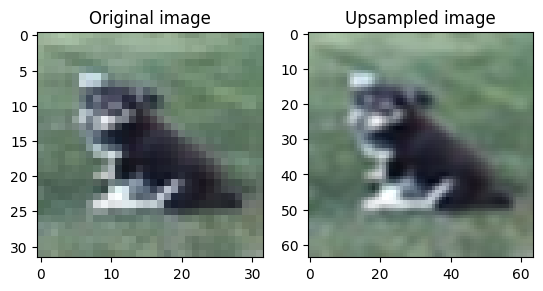

In [8]:
#Visualisation
image, target = train_dataset[70]
image_upsampled = torch.nn.Upsample(size=(64,64), mode="bicubic")(image.unsqueeze(0))
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
image_upsampled = image_upsampled.squeeze(0).permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2)
axs[0].imshow(image)
axs[0].set_title("Original image")
axs[1].imshow(image_upsampled)
axs[1].set_title("Upsampled image")
plt.show()


In [ ]:
#Creating dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)


In [ ]:
class SA_block(torch.nn.Module):

    def __init__(self, d_emb, dk, nb_patches):
        super().__init__()
        self.d_emb = d_emb
        self.dk = dk
        self.nb_patches = nb_patches
        self.W_Q = torch.nn.Linear(in_features=d_emb, out_features=dk)
        self.W_K = torch.nn.Linear(in_features=d_emb, out_features=dk)
        self.W_V = torch.nn.Linear(in_features=d_emb, out_features=dk)

    def forward(self, x):
        #print(x.device, self.W_Q.weight.device)
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)


        #print(K.shape)
        att = torch.matmul(Q, K.transpose(1,2))
        att /= self.dk ** 0.5
        att = torch.softmax(att, dim=-1)
        return torch.matmul(att, V)


In [ ]:
class MHSA(torch.nn.Module):

    def __init__(self, d_emb, dk, nb_heads, nb_patches):
        super().__init__()
        self.d_emb = d_emb
        self.dk = dk
        self.nb_heads = nb_heads
        self.nb_patches = nb_patches
        self.heads = torch.nn.ModuleList([SA_block(d_emb, dk, nb_patches) for _ in range(nb_heads)])
        self.w0 = torch.nn.Linear(in_features=nb_heads * dk, out_features=d_emb)

    def forward(self, x):
        x_cat = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.w0(x_cat)

In [ ]:
class FeedForward(torch.nn.Module):

    def __init__(self, d_emb, dff):
        super().__init__()
        self.dff = dff
        self.d_emb = d_emb
        self.W1 = torch.nn.Linear(in_features=d_emb, out_features=dff)
        self.W2 = torch.nn.Linear(in_features=dff, out_features=d_emb)

    def forward(self, x):
        x = self.W1(x)
        x = torch.nn.ReLU()(x)
        x = self.W2(x)
        return x

In [ ]:
class Block(torch.nn.Module):

    def __init__(self, d_emb, dk, nb_heads, dff, nb_patches, dropout=0.1):
        super().__init__()
        self.d_emb = d_emb
        self.dk = dk
        self.nb_heads = nb_heads
        self.nb_patches = nb_patches
        self.dff = dff
        self.mhsa = MHSA(d_emb, dk, nb_heads, nb_patches)
        self.ff = FeedForward(d_emb, dff)
        self.bn1 = torch.nn.BatchNorm1d(d_emb)
        self.bn2 = torch.nn.BatchNorm1d(d_emb)
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.dropout2 = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        # Apply MHSA and add residual connection
        residual = x
        x = self.dropout1(self.mhsa(x)) + residual

        # Permute dimensions for BatchNorm1d
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        # Permute back to original dimensions
        x = x.permute(0, 2, 1)

        # Apply FeedForward and add residual connection
        residual = x
        x = self.dropout1(self.ff(x)) + residual

        # Permute dimensions for BatchNorm1d
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        # Permute back to original dimensions
        x = x.permute(0, 2, 1)

        return x

In [ ]:
class Model(torch.nn.Module):

  def __init__(self, patch_size, im_channels, d_emb, dk, nb_heads, dff, nb_layers, nb_patches, nb_classes, dropout=0.1):
    super().__init__()
    self.d_emb = d_emb
    self.dk = dk
    self.nb_heads = nb_heads
    self.dff = dff
    self.nb_layers = nb_layers
    self.patch_size = patch_size
    self.nb_patches = nb_patches
    self.nb_classes = nb_classes
    self.pos_emb = torch.nn.Embedding(num_embeddings=nb_patches, embedding_dim=d_emb)
    self.emb_dropout = torch.nn.Dropout(p=dropout)
    self.embed_layer = torch.nn.Linear(in_features=patch_size**2*im_channels, out_features=d_emb)
    self.blocks = torch.nn.ModuleList([Block(d_emb, dk, nb_heads, dff, nb_patches, dropout) for _ in range(nb_layers)])
    self.head = torch.nn.Linear(in_features=d_emb * nb_patches, out_features=nb_classes)

  def make_patches(self, batch, patch_size):
     N, C, H, W = batch.shape
     batch = batch.permute(0, 2, 3, 1)
     assert H % patch_size == 0 and W % patch_size == 0
     nb_patches = (H // patch_size) * (W // patch_size)
     return batch.contiguous().view(N, nb_patches, -1)

  def forward(self, x):
    x = self.make_patches(x, self.patch_size)
    x_pos = self.pos_emb(torch.arange(self.nb_patches, device= x.device))
    x = self.emb_dropout(self.embed_layer(x) + x_pos)
    for block in self.blocks:
      x = block(x)
    x = x.reshape(x.shape[0], -1)
    return self.head(x)


In [ ]:
patch_size = 4
d_emb = 64
dk = 128
nb_heads = 4
dff = d_emb * 4
nb_layers = 4
H, W, im_channels = image.shape
nb_patches = (H // patch_size) * (W // patch_size)
nb_classes = 10
dropout = 0.2
model = Model(patch_size, im_channels, d_emb, dk, nb_heads, dff, nb_layers, nb_patches, nb_classes, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")
model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
model = torch.compile(model)

Device is: cuda
Number of parameters: 712266


In [ ]:
#Training and validation
nb_epochs = 300
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
      if loss.item() < best_loss:
          best_loss = loss.item()
          best_model, best_epoch = model, epoch
    loss_val /= len(test_loader)
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {epoch}")

epochs = range(nb_epochs)
plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

Epoch: 0


0it [00:00, ?it/s]W1026 13:23:41.214000 960 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
782it [01:37,  8.05it/s]
79it [00:20,  3.90it/s]


Loss_train: 2.0511 and loss_val: 1.9293
Epoch: 1


782it [00:20, 38.27it/s]
79it [00:01, 78.30it/s]


Loss_train: 1.9042 and loss_val: 1.8579
Epoch: 2


782it [00:20, 37.57it/s]
79it [00:00, 80.49it/s]


Loss_train: 1.8348 and loss_val: 1.7941
Epoch: 3


782it [00:20, 37.60it/s]
79it [00:01, 78.99it/s]


Loss_train: 1.7798 and loss_val: 1.7419
Epoch: 4


782it [00:20, 37.72it/s]
79it [00:01, 78.21it/s]


Loss_train: 1.7364 and loss_val: 1.6997
Epoch: 5


782it [00:20, 38.78it/s]
79it [00:01, 67.66it/s]


Loss_train: 1.6949 and loss_val: 1.6805
Epoch: 6


782it [00:20, 37.96it/s]
79it [00:00, 79.95it/s]


Loss_train: 1.6660 and loss_val: 1.6365
Epoch: 7


782it [00:20, 37.60it/s]
79it [00:00, 79.55it/s]


Loss_train: 1.6313 and loss_val: 1.6101
Epoch: 8


290it [00:07, 36.34it/s]


KeyboardInterrupt: 

In [ ]:
#Test
model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(test_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(test_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(test_loader)

  print(f"Loss_test: {loss_test:.4f}")




Now testing...


79it [00:01, 55.89it/s]

Loss_test: 1.1656


<Axes: >

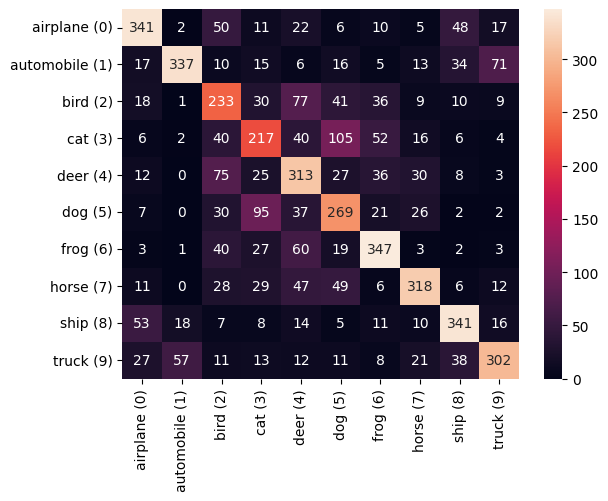

In [ ]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [ ]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.6036


In [ ]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)


                Accuracy
ship (8)        0.706004
frog (6)        0.687129
airplane (0)    0.666016
automobile (1)  0.643130
horse (7)       0.628458
truck (9)       0.604000
deer (4)        0.591682
dog (5)         0.550102
bird (2)        0.502155
cat (3)         0.444672
